# Proyek Klasifikasi Gambar: Drone vs Bird
- **Nama:** Novia Ayu Fitriana
- **Email:** noviaayufitriana25@gmail.com
- **ID Dicoding:** noviaayu

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflow tensorflowjs

In [1]:
# --- Import libraries yang diperlukan ---
import os
import io
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import files

#Upload file dari lokal
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"noviaayufitriana","key":"5acf0065cf29c1efdabfc3ff6ec62661"}'}

In [4]:
# Menyalin kredensial Kaggle untuk mengakses dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Mengunduh dataset dari Kaggle
!kaggle datasets download -d muhammadsaoodsarwar/drone-vs-bird

Dataset URL: https://www.kaggle.com/datasets/muhammadsaoodsarwar/drone-vs-bird
License(s): apache-2.0


In [6]:
# Mengekstrak dataset yang telah diunduh
!unzip drone-vs-bird.zip

Archive:  drone-vs-bird.zip
  inflating: dataset/bird/100.jpg    
  inflating: dataset/bird/101.jpg    
  inflating: dataset/bird/102.jpg    
  inflating: dataset/bird/103.jpg    
  inflating: dataset/bird/104.jpg    
  inflating: dataset/bird/105.jpg    
  inflating: dataset/bird/107.jpg    
  inflating: dataset/bird/109.jpg    
  inflating: dataset/bird/110.jpg    
  inflating: dataset/bird/111.jpg    
  inflating: dataset/bird/112.jpg    
  inflating: dataset/bird/113.jpg    
  inflating: dataset/bird/114.jpg    
  inflating: dataset/bird/116.jpg    
  inflating: dataset/bird/117.jpg    
  inflating: dataset/bird/118.jpg    
  inflating: dataset/bird/119.jpg    
  inflating: dataset/bird/120.jpg    
  inflating: dataset/bird/121.jpg    
  inflating: dataset/bird/122.jpg    
  inflating: dataset/bird/123.jpg    
  inflating: dataset/bird/124.jpg    
  inflating: dataset/bird/125.jpg    
  inflating: dataset/bird/126.jpg    
  inflating: dataset/bird/128.jpg    
  inflating: dataset/b

In [7]:
# Lihat struktur folder setelah ekstrak
os.listdir("dataset")

['drone', 'bird']

In [8]:
# Lokasi dataset asal
base_dir = '/content/dataset'

# Lokasi baru setelah di-split
output_dir = '/content/dataset_split'
os.makedirs(output_dir, exist_ok=True)

# Rasio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Proses setiap class
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=(1-train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio/(test_ratio+val_ratio)), random_state=42)

    for phase, phase_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        phase_class_dir = os.path.join(output_dir, phase, class_name)
        os.makedirs(phase_class_dir, exist_ok=True)
        for img in phase_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(phase_class_dir, img))

print("Dataset berhasil di-split ke dalam train/val/test!")

Dataset berhasil di-split ke dalam train/val/test!


In [9]:
train_dir = 'dataset_split/train'
valid_dir = 'dataset_split/val'
test_dir = 'dataset_split/test'

### Data Preprocessing

#### Split Dataset

In [10]:
# Path utama
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk menghitung jumlah gambar per kategori
def count_images(directory):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            print(f"Kategori '{category}': {num_images} gambar")

# Hitung isi setiap folder
print("Jumlah gambar di TRAIN folder:")
count_images(train_dir)

print("\nJumlah gambar di VAL folder:")
count_images(val_dir)

print("\nJumlah gambar di TEST folder:")
count_images(test_dir)

Jumlah gambar di TRAIN folder:
Kategori 'drone': 1749 gambar
Kategori 'bird': 1124 gambar

Jumlah gambar di VAL folder:
Kategori 'drone': 375 gambar
Kategori 'bird': 241 gambar

Jumlah gambar di TEST folder:
Kategori 'drone': 375 gambar
Kategori 'bird': 242 gambar


In [11]:
# Path utama
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk menghitung total gambar dalam folder
def count_total_images(directory):
    total = 0
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            total += len(os.listdir(category_path))
    return total

# Hitung total
total_train = count_total_images(train_dir)
total_val = count_total_images(val_dir)
total_test = count_total_images(test_dir)

# Cetak hasil
print(f"Total gambar di TRAIN: {total_train}")
print(f"Total gambar di VAL: {total_val}")
print(f"Total gambar di TEST: {total_test}")


Total gambar di TRAIN: 2873
Total gambar di VAL: 616
Total gambar di TEST: 617


In [12]:
# Preprocessing dan Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


In [13]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2872 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


## Modelling

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [18]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.6846 - loss: 0.6078 - val_accuracy: 0.7727 - val_loss: 0.4607
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.8089 - loss: 0.4092 - val_accuracy: 0.8214 - val_loss: 0.3914
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.8408 - loss: 0.3476 - val_accuracy: 0.8182 - val_loss: 0.3983
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.8581 - loss: 0.3236 - val_accuracy: 0.8766 - val_loss: 0.3492
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8705 - loss: 0.2912 - val_accuracy: 0.8425 - val_loss: 0.3562
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.8788 - loss: 0.2830 - val_accuracy: 0.8782 - val_loss: 0.3248
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.8857 - loss: 0.2717 - val_accuracy: 0.8945 - val_loss: 0.2815
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.8889 - loss: 0.2560 - val_accuracy: 0.9026 - v

## Evaluasi dan Visualisasi

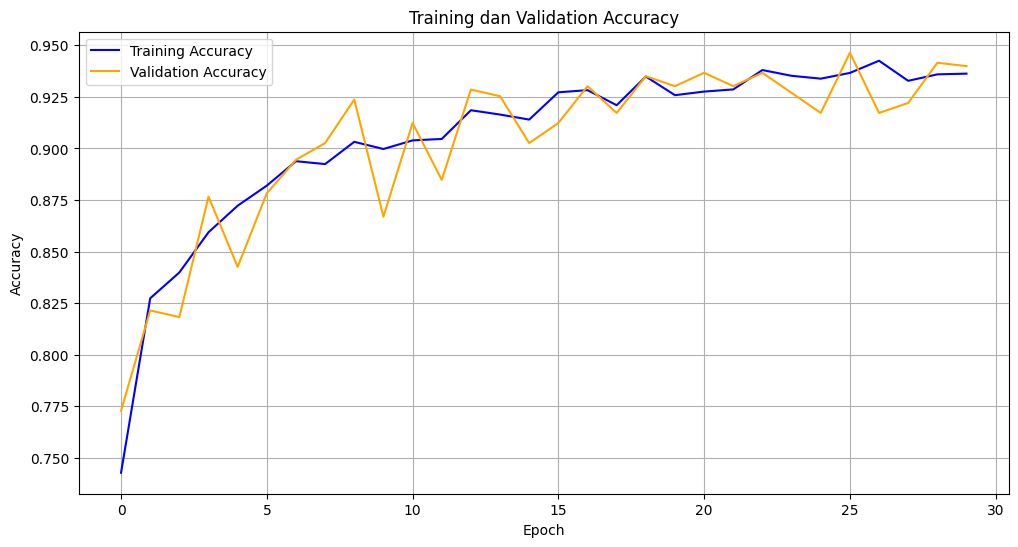

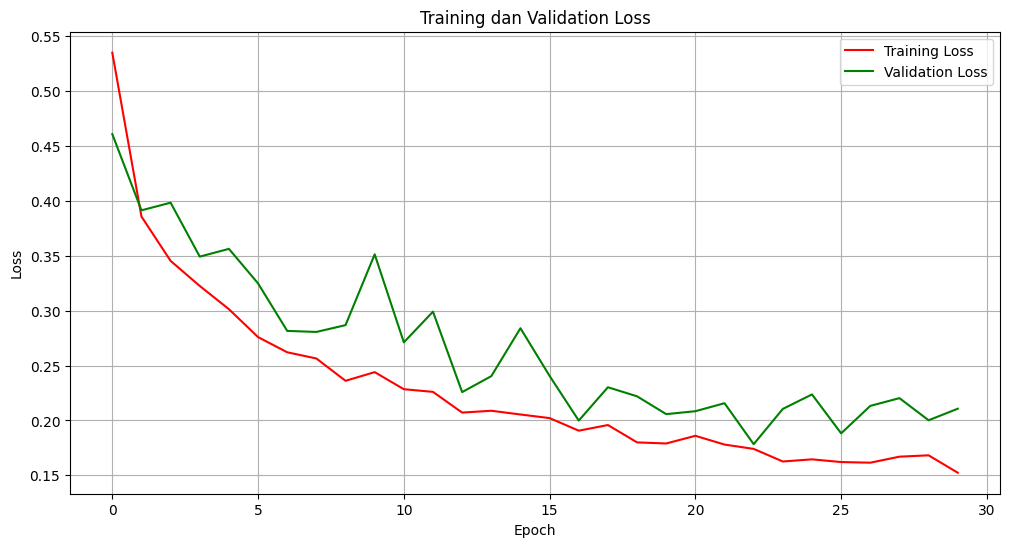

In [20]:
# Plot Akurasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training dan Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Training dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Evaluasi model pada data latih
train_loss, train_acc = model.evaluate(train_generator)
print(f"Akurasi Data Latih: {train_acc:.2%}")

# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi Data Uji: {test_acc:.2%}")

# Mengecek apakah akurasi lebih dari 85%
if train_acc >= 0.85 and test_acc >= 0.85:
    print("Akurasi pada training dan testing set sudah memenuhi kriteria 85%!")
else:
    print("Akurasi belum mencapai target 85%.")


90/90 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9385 - loss: 0.1598
Akurasi Data Latih: 94.32%
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9400 - loss: 0.1608
Akurasi Data Uji: 93.18%
Akurasi pada training dan testing set sudah memenuhi kriteria 85%!


## Konversi Model

In [22]:
# Save model in SavedModel format
tf.saved_model.save(model, 'saved_model')

In [23]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Save TFLite model
with open('drone_bird_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [37]:
os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

In [24]:
label = ['drone', 'bird']
with open('label.txt', 'w') as f:
    f.write('\n'.join(label))

In [27]:
pip install tensorflowjs

In [28]:
!tensorflowjs_converter --version

2025-04-28 10:33:33.926580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745836414.480196   36241 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745836414.616584   36241 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!

tensorflowjs 4.22.0

Dependency versions:
  keras 2.18.0
  tensorflow 2.18.0


In [29]:
# Convert to TensorFlow.js format
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='dense_1/Softmax' --saved_model_tags=serve saved_model/drone_bird_model tfjs_model/

2025-04-28 10:34:09.800767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745836449.825491   36402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745836449.832742   36402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib

In [36]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-28 10:42:00.902759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745836920.930081   38334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745836920.937551   38334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-28 10:42:06.891301: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745836927.731087   38334 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

In [30]:
img_path = test_dir + '/bird/160.jpg'

# Periksa apakah file ada
if os.path.exists(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Map label
    class_indices = train_generator.class_indices
    labels = dict((v, k) for k, v in class_indices.items())

    print(f'Gambar ini diprediksi sebagai: {labels[predicted_class]}')
else:
    print(f"File gambar tidak ditemukan di path: {img_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Gambar ini diprediksi sebagai: bird


Saving bird5.png to bird5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


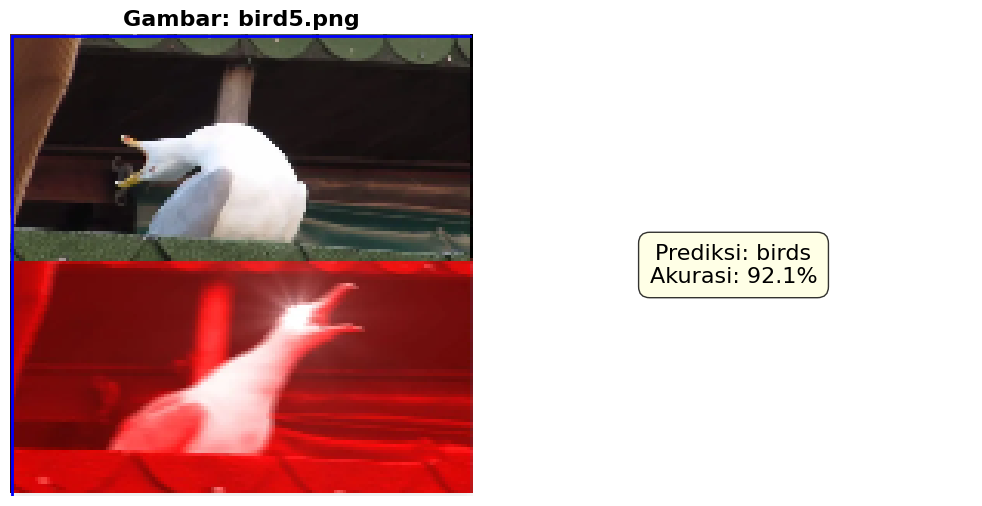


Hasil: birds (92.1% akurat)


In [38]:
# Unggah gambar yang ingin diprediksi
uploaded = files.upload()

for filename in uploaded.keys():
    # Membaca gambar yang di-upload
    img_bytes = uploaded[filename]
    img = image.load_img(io.BytesIO(img_bytes), target_size=(150, 150))

    # Mengubah gambar menjadi array dan melakukan normalisasi
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class_idx = np.argmax(prediction)  # Index kelas dengan prediksi tertinggi
    confidence_pct = np.max(prediction) * 100  # Akurasi prediksi dalam persen

    # Mapping dari index ke nama kelas
    class_indices = {'birds': 0, 'drone': 1}  # Sesuaikan dengan class index modelmu
    predicted_class = list(class_indices.keys())[predicted_class_idx]

    # Menampilkan gambar dan hasil prediksi
    plt.figure(figsize=(10, 5))

    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Gambar: {filename}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((0, 0), 150, 150, linewidth=2, edgecolor='blue', facecolor='none'))

    # Hasil prediksi
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5,
             f"Prediksi: {predicted_class}\nAkurasi: {confidence_pct:.1f}%",
             fontsize=16,
             ha='center', va='center',
             bbox=dict(facecolor='lightyellow', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Cetak hasil di konsol
    print(f"\nHasil: {predicted_class} ({confidence_pct:.1f}% akurat)")

In [39]:
!pip freeze > requirements.txt